### SRF January Phase and Range Model Build for Keras
This notebook is an update of all the code I have been compiling in January 2023 for SRF/Roke. The aim is to train an ML model to recognise 5 different settings on the SRF box.

I have included both phase and range information and flattened it in the original list to make compiling the model easier.

I took 100 scans of each of the test positions - so this is a very basic system but extensible and fine for demo purposes.

Classifiers are as follows:
* 0 = Control (box as is)
* 1 = A spanner placed in the middle of the box (head down)
* 2 = Little gap in box opening - spanner wedged in middle thin ways
* 3 = Big gap in box opening - spanner wedged in width ways
* 4 = Human hand on middle of box






## Capture data for multiple labels to build a data array:
### !!This will overwrite the current 'data.npy' file so take care!!
The code below will build an array for you to use in training the machine learning model. You will need to assign an integer and lebel to each class and tell the programme how many runs of each class you want to do.

As a precaution I reccomend you delete the existing "data.npy" file (after backing it up somewhere else safely).

IMPORTANT - in the code below it will stop after all the runs have been done but you need to MANUALLY HIT STOP in the cell menu toolbar in order for the file to compile and save properly. It's probably a TODO to fix that but I am not going to mess about with it now it works!

In [ ]:
#Looks OK as of 15/1/24 but something went haywire and the whole thing needed to calm down!
import time
import SiRad
import numpy as np

def run_measurement_and_save(num_arrays):
    MySiRad = SiRad.SiRadDriver()

    try:
        # Initialize an empty list to store arrays
        data_arrays = []

        for _ in range(num_arrays):
            try:
                label = input("Enter the label for the training data: ")
            except KeyboardInterrupt:
                # Close SiRad connection on keyboard interrupt
                MySiRad.close()
                print("\nMeasurement and save interrupted.")
                save_data_to_file(data_arrays)
                return

            for _ in range(num_arrays):  # Corrected loop structure
                print('Taking fingerprint')

                # Run a measurement
                MySiRad.measure()

                # Get measurement data
                fingerprint = MySiRad.RangeData_dB
                fingerprint2 = MySiRad.PhaseData_degrees
                #print(fingerprint) # Test line to make sure fingerprint is capturing!

                # Combine both readings into the same array along with the label
                largearray = np.array([fingerprint + fingerprint2, label])  # label is now a separate element


                # Append the array to the list
                data_arrays.append(largearray)

                # Print array shape
                print(largearray.shape)

                # Sleep for 0.2 seconds
                time.sleep(0.1)

        # Load existing data (if any)
        try:
            existing_data = np.load("data.npy", allow_pickle=True)
            data_arrays.extend(existing_data.tolist())
        except FileNotFoundError:
            pass

        # Save all arrays to file
        save_data_to_file(data_arrays)

    finally:
        # Close SiRad connection regardless of exceptions
        MySiRad.close()

def save_data_to_file(data_arrays):
    # Save data to file, overwriting existing file
    np.save("data.npy", np.array(data_arrays))

if __name__ == "__main__":
    # Get the number of arrays from the user
    num_arrays = int(input("Enter the number of arrays to generate for each label: "))

    # Run the measurement and save loop
    run_measurement_and_save(num_arrays)

## Training the model in Tensorflow:

In [ ]:
# TensorFlow and tf.keras
import tensorflow as tf

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

2024-01-15 16:33:32.634371: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2.12.0


This is the data array from my other 2023 notebook. I can take a slice and plot it. This is stored in the "TF for Oil and Gas folder" top level.

In [ ]:
# Load data
data = np.load("data.npy", allow_pickle=True)

A quick check to make sure I have the right data by slicing out a scan and plotting it. You can see this is not yet normalised.

In [ ]:
print(data.shape)
result = [arr[0][:512] for arr in data]





(2500, 2)


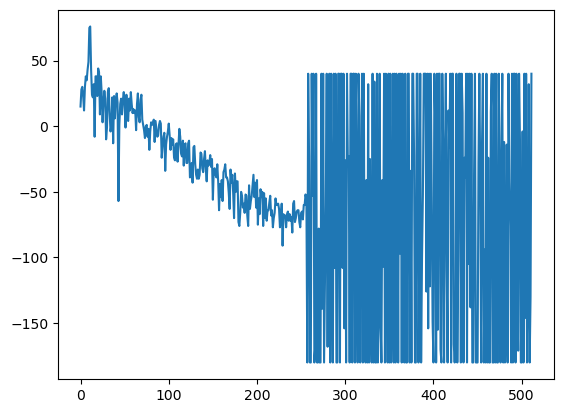

In [ ]:
plt.figure()
plt.plot(result[3])
plt.show()


Some post processing is required as I need to reshape the array so it is suitable for Keras.

In [ ]:
data.shape
data

array([[list([14, 28, 30, 23, 12, 30, 38, 35, 43, 49, 75, 76, 43, 24, 22, 32, -9, 38, 37, 23, 44, 41, 9, 38, 25, 3, 18, 27, 21, -10, -1, 27, 29, 10, -1, 0, 22, -14, 23, 5, 19, 25, 18, -49, 1, 17, 21, 9, 20, 26, 17, -1, 24, 8, 4, 21, 12, 26, 17, 10, 13, 10, 12, -3, 17, 25, 7, 3, 20, 24, 5, 1, -3, -9, 0, 1, -8, -1, -18, -4, 3, 2, 2, 5, -12, 4, -2, -9, -6, 1, 4, 2, -23, -14, -9, -5, -34, -14, -8, -5, 2, -6, -18, -9, -14, -10, -25, -26, -14, -13, -27, -15, -2, -8, -22, -23, -10, -29, -14, -12, -28, -28, -14, -11, -38, -37, -28, -42, -17, -14, -30, -36, -43, -33, -38, -37, -21, -20, -31, -35, -25, -18, -33, -42, -27, -30, -29, -22, -31, -25, -59, -33, -33, -38, -38, -29, -41, -62, -43, -52, -41, -55, -35, -33, -30, -40, -38, -42, -55, -63, -33, -42, -37, -53, -71, -36, -49, -42, -42, -78, -69, -64, -49, -52, -62, -57, -63, -53, -54, -67, -75, -48, -64, -56, -57, -45, -36, -53, -43, -62, -41, -72, -55, -60, -45, -56, -50, -73, -52, -75, -54, -68, -61, -66, -57, -51, -67, -63, -71, -77, -72, 

I now need to extract the label and list items from that numpy array ready for recombining.

In [ ]:
# Extract the first column (containing the lists) and then slice each list to get the first 512 items
lists = [arr[0][:512] for arr in data]

# Extract the second column (containing the labels)
labels = [arr[1] for arr in data]

# 'lists' will contain the lists with the first 512 items
# 'labels' will contain the associated labels

# I need to combine these labels and lists into a trainable array


This will turn the lists and labels into proper numpy arrays for processing in the correct shape.

**It is important to note that the labels array needs to be changed from "U1" data format to "int64" in order to work with Keras!** The code below does this for the labels array. The lists array is OK as is.

In [ ]:
lists = np.array(lists)
# Assuming labels is loaded as an array with inferred data type
labels = np.array(labels, dtype=np.int64)
print(labels.shape)
print(lists.shape)
print(labels.dtype)
print(lists.dtype)





(2500,)
(2500, 512)
int64
int64


## Normalise the lists array:

The code below will take the lists array of scans and normalises it to ranges between 0 - 1. This is important as Tensorflow needs data to be normalised in order to work properly!

As a sanity check I take a slice from the original array and compare to the normalised one.

The code below takes a single array and converts it.

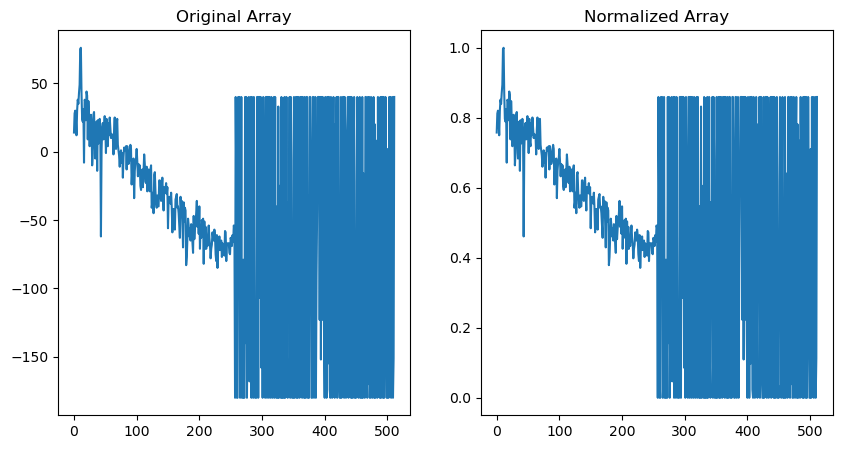

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming X_train[340] is your original array
original_array = lists[340]

# Convert the array to np.int64 (if necessary)
new_list_item_array = np.array(original_array, dtype=np.int64)

# Min-Max scaling
min_value = np.min(new_list_item_array)
max_value = np.max(new_list_item_array)

normalized_array = (new_list_item_array - min_value) / (max_value - min_value)

# Plot the original and normalized arrays
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(new_list_item_array)
plt.title('Original Array')

plt.subplot(1, 2, 2)
plt.plot(normalized_array)
plt.title('Normalized Array')

plt.show()

## Normalise entire array of lists:

This code iterates over the entire lists array and normalises each scan within it:

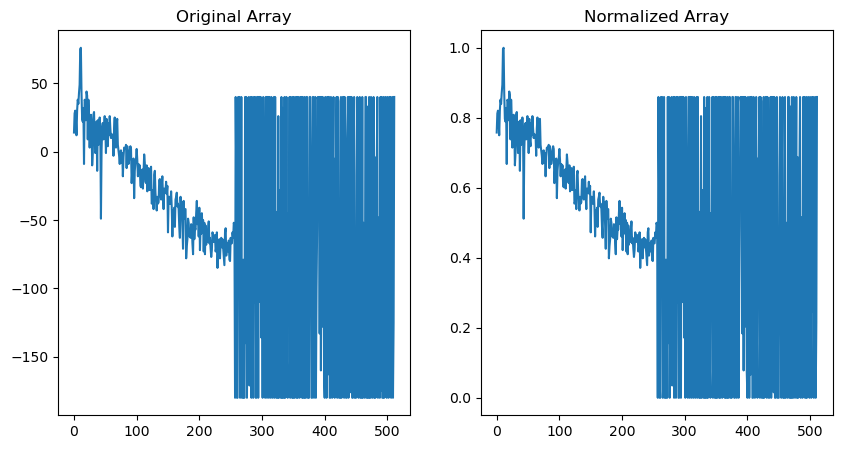

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming lists is your 2D numpy array with shape (500, 512)
# You can replace it with your actual array
lists2 = lists  # Example random array

# Initialize an empty array to store normalized arrays
normalized_arrays = np.zeros_like(lists, dtype=np.float64)

# Iterate over each array in the 2D array and normalize
for i in range(lists2.shape[0]):
    original_array = lists2[i]

    # Convert the array to np.int64 (if necessary)
    new_list_item_array = np.array(original_array, dtype=np.int64)

    # Min-Max scaling
    min_value = np.min(new_list_item_array)
    max_value = np.max(new_list_item_array)

    normalized_array = (new_list_item_array - min_value) / (max_value - min_value)

    # Store the normalized array in the new array
    normalized_arrays[i, :] = normalized_array

# Plot the original and normalized arrays for a specific item (e.g., first item)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(lists2[0, :])
plt.title('Original Array')

plt.subplot(1, 2, 2)
plt.plot(normalized_arrays[0, :])
plt.title('Normalized Array')

plt.show()


In [ ]:
normalized_arrays.shape


(2500, 512)

The code above works for normalising the whole array! Now redo the model with the new normalized_array - change to lists!

In [ ]:
lists = normalized_arrays
lists.shape

(2500, 512)

# Build the model:

## Build, Train and Test the model

This example creates a simple feedforward neural network with one input layer, two hidden layers, and one output layer. Adjust the architecture based on your specific requirements. The model is then compiled, trained, and evaluated. Finally, the trained model is saved.

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical

# Assuming 'lists' and 'labels' are your lists and labels arrays

# Convert lists and labels to numpy arrays
lists = np.array(lists)
labels = np.array(labels)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(lists, labels, test_size=0.2, random_state=42)

# Convert labels to categorical one-hot encoding
num_classes = len(np.unique(labels))
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

# Define a simple neural network model
model = Sequential()
model.add(Dense(64, input_shape=(X_train.shape[1],), activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1)

# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')

# Save the trained model
model.save('your_model-6.h5')  # Replace 'your_model.h5' with the desired file name

model.summary()

Epoch 1/10
57/57 [==============================] - 2s 8ms/step - loss: 0.4568 - accuracy: 0.8889 - val_loss: 0.0331 - val_accuracy: 1.0000
Epoch 2/10
57/57 [==============================] - 0s 4ms/step - loss: 0.0153 - accuracy: 1.0000 - val_loss: 0.0073 - val_accuracy: 1.0000
Epoch 3/10
57/57 [==============================] - 0s 4ms/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 0.0036 - val_accuracy: 1.0000
Epoch 4/10
57/57 [==============================] - 0s 3ms/step - loss: 0.0029 - accuracy: 1.0000 - val_loss: 0.0022 - val_accuracy: 1.0000
Epoch 5/10
57/57 [==============================] - 0s 5ms/step - loss: 0.0018 - accuracy: 1.0000 - val_loss: 0.0015 - val_accuracy: 1.0000
Epoch 6/10
57/57 [==============================] - 0s 5ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.0011 - val_accuracy: 1.0000
Epoch 7/10
57/57 [==============================] - 0s 4ms/step - loss: 9.5228e-04 - accuracy: 1.0000 - val_loss: 8.5184e-04 - val_accuracy: 1.0000
Epoch 8/10
5

Sanity check here that you have properly reshaped and reasonable sizes of arrays.

In [ ]:
print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)



Shape of X_train: (2000, 512)
Shape of y_train: (2000, 5)
Shape of X_test: (500, 512)
Shape of y_test: (500, 5)


Sanity check that the data looks reaosnable:

In [ ]:
# Print a few samples from the training set
for i in range(5):
    print("Sample {}: X = {}, y = {}".format(i+1, X_train[i], y_train[i]))

# Print a few samples from the testing set
for i in range(5):
    print("Sample {}: X = {}, y = {}".format(i+1, X_test[i], y_test[i]))


Sample 1: X = [0.76953125 0.8125     0.8203125  0.79296875 0.7578125  0.80859375
 0.84765625 0.83203125 0.85546875 0.90234375 0.99609375 1.
 0.8671875  0.82421875 0.77734375 0.7890625  0.78125    0.859375
 0.84765625 0.65625    0.88671875 0.8828125  0.79296875 0.83203125
 0.73046875 0.76953125 0.734375   0.80859375 0.78515625 0.671875
 0.73046875 0.7890625  0.7578125  0.703125   0.71484375 0.7265625
 0.80859375 0.7109375  0.81640625 0.80859375 0.6875     0.78515625
 0.73828125 0.6953125  0.6796875  0.77734375 0.8125     0.7890625
 0.79296875 0.74609375 0.7578125  0.7265625  0.79296875 0.68359375
 0.7578125  0.74609375 0.75390625 0.703125   0.734375   0.71484375
 0.76171875 0.7578125  0.73828125 0.78515625 0.75       0.7578125
 0.7734375  0.703125   0.7578125  0.71484375 0.734375   0.734375
 0.65625    0.6953125  0.73828125 0.6875     0.6953125  0.6875
 0.68359375 0.70703125 0.74609375 0.73828125 0.6328125  0.65234375
 0.69140625 0.69921875 0.59765625 0.66796875 0.61328125 0.61328125
 0

This code manually saves and downloads the trained model for use later. Thjis block saves it on a local system in the working directory:

In [ ]:
from tensorflow.keras.models import load_model

# Assuming you have trained and compiled your Keras model and stored it in a variable named 'model'
# Example: model = ... (your Keras model definition and training code)

# Save the model - this will save the model locally if running on a local notebook in the working directory
model.save('your_model-6.h5')  # Replace 'your_model.h5' with the desired file name



The following code saves a local compiled model for using in tests along with a back up to save to my google colab directory.

In [ ]:
# Now, you can download the saved model to your local machine
#The code below only works if you are running on the google colab notebook
#
from google.colab import files
files.download('your_model.h5')

In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/gdrive')

# Save the model to Google Drive
model.save('/content/gdrive/MyDrive/your_model.h5')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Now to test the model!
This is from chat GPT to compare the scan to the model.


To test a new list item against a trained Keras model, you need to follow these general steps:

Preprocess the New List Item:
 - Ensure that the new list item is preprocessed in the same way as your training data. This includes any normalization, scaling, or other preprocessing steps that were applied to the training data.
Use the Trained Model to Make Predictions:
- Load your pre-trained Keras model and use it to make predictions on the preprocessed new list item. The model's predict function can be used for this.
Interpret the Predictions:
- Interpret the model's predictions. If you are working on a classification task, the output of the predict function will be a probability distribution over the classes. You can take the class with the highest probability as the predicted class.

Here's an example assuming you have already trained a model:

This line is where it takes in the new array. **make sure you normalise any new array you feed into this**:

new_list_item_array = np.array(np.array(X_test[40], dtype=np.int64))

In [ ]:
#THIS WORKS!!!!!!!!
import numpy as np
from tensorflow.keras.models import load_model

# Load the pre-trained model
model = load_model('your_model-6.h5')  # Replace 'your_model.h5' with the actual file path

# Assuming 'new_list_item' is your new list item
# Ensure to preprocess 'new_list_item' in the same way as your training data

# Convert 'new_list_item' to a NumPy array
# I have added a conversion to turn the list into int64 datatype as I hope this will work better
new_list_item_array = np.array(np.array(X_test[40], dtype=np.int64))

# Reshape the input to match the expected shape (batch_size, 512)
new_list_item_array = new_list_item_array.reshape((1, 512))

# Make predictions
predictions = model.predict(new_list_item_array)

# Interpret the predictions (assuming a classification task)
predicted_class = np.argmax(predictions)

print("Predicted Class:", predicted_class)


1/1 [==============================] - 0s 148ms/step
Predicted Class: 2


The code below is a quick sanity check to make sure I have the right number of classifiers for identification. In this case there should be 5.

In [ ]:
num_classes = model.layers[-1].output_shape[1]
print("Number of classes:", num_classes)


Number of classes: 5


Below is a full belt and braces sanity check to make sure the array you put in the classifer model for checking is still the right kind of data!:

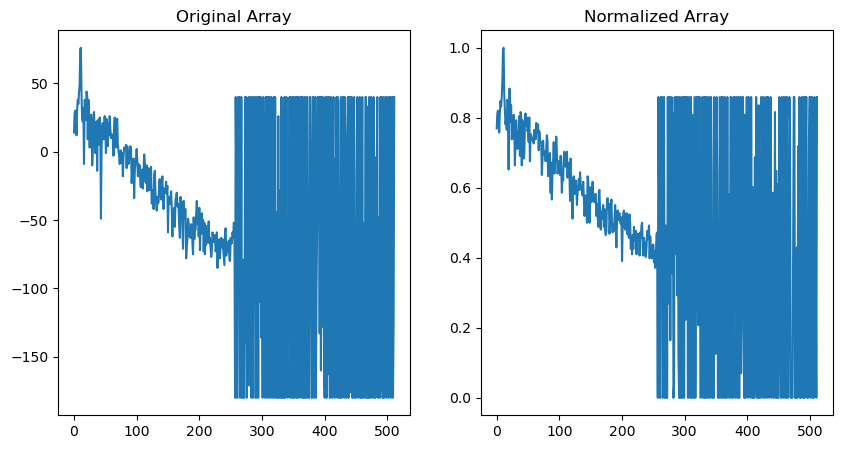

In [ ]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(lists2[0, :])
plt.title('Original Array')

plt.subplot(1, 2, 2)
plt.plot(X_test[40])
plt.title('Normalized Array')

plt.show()